In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from kaggle_competitions.spaceship_titanic.run import load_test, load_train

df_train = load_train()
df_test = load_test()
rs = 42
scoring_funcs = ("precision", "recall", "accuracy")
df_train.head(2)


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [3]:
df_train["CryoSleep"].value_counts(dropna=False)


CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import pandas as pd

tr = ColumnTransformer(
    [
        (
            "cat_na",
            SimpleImputer(strategy="constant", fill_value="unk"),
            [
                "HomePlanet",
            ],
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
new_ = tr.fit_transform(df_train)
pd.DataFrame(new_, columns=tr.get_feature_names_out())


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [5]:
df_test.head(2)


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
PassengerId,,,,,,,,,,,,
0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import cross_validate
from kaggle_competitions.metrics import metrics

target_col = "Transported"
pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [("age", SimpleImputer(strategy="most_frequent"), ["Age"])], verbose_feature_names_out=False
            ),
        ),
        ("quantize", ColumnTransformer([("age", QuantileTransformer(), [0])])),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)
x, y = df_train.drop(columns=[target_col]), 1 * df_train[target_col]
cv = cross_validate(pipe, x, y, scoring=("precision", "recall", "accuracy"))
metrics.from_cv("main", cv)


In [7]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy="most_frequent", random_state=rs)
clf.fit(x, y)
metrics.from_cv("baseline", cross_validate(clf, x, y, scoring=("precision", "recall", "accuracy")))


In [8]:
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624


In [9]:
pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    ("Age", SimpleImputer(strategy="most_frequent"), ["Age"]),
                    ("RoomService", SimpleImputer(strategy="constant", fill_value=0), ["RoomService"]),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        (
            "quantize",
            ColumnTransformer(
                [
                    ("age", QuantileTransformer(), [0]),
                    ("room_service", QuantileTransformer(), [1]),
                ]
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=("precision", "recall", "accuracy"))
metrics.from_cv("add_room_service", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810


In [10]:
pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    ("Age", SimpleImputer(strategy="most_frequent"), ["Age"]),
                    ("RoomService", SimpleImputer(strategy="constant", fill_value=0), ["RoomService"]),
                    ("CryoSleep", SimpleImputer(strategy="constant", fill_value=False), ["CryoSleep"]),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        (
            "quantize",
            ColumnTransformer(
                [
                    ("age", QuantileTransformer(), [0]),
                    ("room_service", QuantileTransformer(), [1]),
                ],
                remainder="passthrough",
                verbose_feature_names_out=False,
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=("precision", "recall", "accuracy"))
metrics.from_cv("add_cryo_sleep", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416


In [11]:
from sklearn.pipeline import make_pipeline

pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    ("Age", make_pipeline(SimpleImputer(strategy="most_frequent"), QuantileTransformer()), ["Age"]),
                    (
                        "RoomService",
                        make_pipeline(SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()),
                        ["RoomService"],
                    ),
                    ("CryoSleep", SimpleImputer(strategy="constant", fill_value=False), ["CryoSleep"]),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=("precision", "recall", "accuracy"))
metrics.from_cv("add_cryo_sleep_2", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416


In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    ("Age", make_pipeline(SimpleImputer(strategy="most_frequent"), QuantileTransformer()), ["Age"]),
                    (
                        "RoomService",
                        make_pipeline(SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()),
                        ["RoomService"],
                    ),
                    ("CryoSleep", SimpleImputer(strategy="most_frequent", fill_value=False), ["CryoSleep"]),
                    (
                        "HomePlanet",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                        ["HomePlanet"],
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=("precision", "recall", "accuracy"))
metrics.from_cv("add_home_planet", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184


In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    ("Age", make_pipeline(SimpleImputer(strategy="most_frequent"), QuantileTransformer()), ["Age"]),
                    (
                        "RoomService",
                        make_pipeline(SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()),
                        ["RoomService"],
                    ),
                    ("CryoSleep", SimpleImputer(strategy="most_frequent", fill_value=False), ["CryoSleep"]),
                    (
                        "HomePlanet",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), OrdinalEncoder()),
                        ["HomePlanet"],
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=("precision", "recall", "accuracy"))
metrics.from_cv("add_home_planet_ord", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069


In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    ("Age", make_pipeline(SimpleImputer(strategy="most_frequent"), QuantileTransformer()), ["Age"]),
                    (
                        "RoomService",
                        make_pipeline(SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()),
                        ["RoomService"],
                    ),
                    (
                        "false_most_freq",
                        SimpleImputer(strategy="most_frequent", fill_value=False),
                        ["CryoSleep", "VIP"],
                    ),
                    (
                        "HomePlanet",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                        ["HomePlanet"],
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=("precision", "recall", "accuracy"))
metrics.from_cv("add_vip", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069
add_vip,0.718492,0.665369,0.700104


In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    ("Age", make_pipeline(SimpleImputer(strategy="most_frequent"), QuantileTransformer()), ["Age"]),
                    (
                        "quant_money",
                        make_pipeline(SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()),
                        ["RoomService", "FoodCourt"],
                    ),
                    (
                        "false_most_freq",
                        SimpleImputer(strategy="most_frequent", fill_value=False),
                        ["CryoSleep", "VIP"],
                    ),
                    (
                        "HomePlanet",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                        ["HomePlanet"],
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=("precision", "recall", "accuracy"))
metrics.from_cv("add_FoodCourt", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069
add_vip,0.718492,0.665369,0.700104
add_FoodCourt,0.728253,0.719732,0.723341


In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    ("Age", make_pipeline(SimpleImputer(strategy="most_frequent"), QuantileTransformer()), ["Age"]),
                    (
                        "quant_money",
                        make_pipeline(SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()),
                        ["RoomService", "FoodCourt", "VRDeck"],
                    ),
                    (
                        "false_most_freq",
                        SimpleImputer(strategy="most_frequent", fill_value=False),
                        ["CryoSleep", "VIP"],
                    ),
                    (
                        "HomePlanet",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                        ["HomePlanet"],
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=("precision", "recall", "accuracy"))
metrics.from_cv("add_VRDeck", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069
add_vip,0.718492,0.665369,0.700104
add_FoodCourt,0.728253,0.719732,0.723341
add_VRDeck,0.751143,0.746003,0.747155


In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    ("Age", make_pipeline(SimpleImputer(strategy="most_frequent"), QuantileTransformer()), ["Age"]),
                    (
                        "quant_money",
                        make_pipeline(SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()),
                        ["RoomService", "FoodCourt", "VRDeck", "Spa"],
                    ),
                    (
                        "false_most_freq",
                        SimpleImputer(strategy="most_frequent", fill_value=False),
                        ["CryoSleep", "VIP"],
                    ),
                    (
                        "HomePlanet",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                        ["HomePlanet"],
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=scoring_funcs)
metrics.from_cv("add_Spa", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069
add_vip,0.718492,0.665369,0.700104
add_FoodCourt,0.728253,0.719732,0.723341
add_VRDeck,0.751143,0.746003,0.747155


In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    ("Age", make_pipeline(SimpleImputer(strategy="most_frequent"), QuantileTransformer()), ["Age"]),
                    (
                        "quant_money",
                        make_pipeline(SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()),
                        ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"],
                    ),
                    (
                        "false_most_freq",
                        SimpleImputer(strategy="most_frequent", fill_value=False),
                        ["CryoSleep", "VIP"],
                    ),
                    (
                        "HomePlanet",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                        ["HomePlanet"],
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=scoring_funcs)
metrics.from_cv("add_ShoppingMall", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069
add_vip,0.718492,0.665369,0.700104
add_FoodCourt,0.728253,0.719732,0.723341
add_VRDeck,0.751143,0.746003,0.747155


In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    (
                        "Age",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), QuantileTransformer(n_quantiles=50)),
                        ["Age"],
                    ),
                    (
                        "quant_money",
                        make_pipeline(SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()),
                        ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"],
                    ),
                    (
                        "false_most_freq",
                        SimpleImputer(strategy="most_frequent", fill_value=False),
                        ["CryoSleep", "VIP"],
                    ),
                    (
                        "HomePlanet",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                        ["HomePlanet"],
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        ("model", RandomForestClassifier(random_state=rs)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=scoring_funcs)
metrics.from_cv("age_less_quant", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069
add_vip,0.718492,0.665369,0.700104
add_FoodCourt,0.728253,0.719732,0.723341
add_VRDeck,0.751143,0.746003,0.747155


In [145]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from catboost import CatBoostClassifier

pipe = Pipeline(
    [
        (
            "fillna",
            ColumnTransformer(
                [
                    (
                        "Age",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), QuantileTransformer(n_quantiles=50)),
                        ["Age"],
                    ),
                    (
                        "quant_money",
                        make_pipeline(SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()),
                        ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"],
                    ),
                    (
                        "false_most_freq",
                        SimpleImputer(strategy="most_frequent", fill_value=False),
                        ["CryoSleep", "VIP"],
                    ),
                    (
                        "HomePlanet",
                        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                        ["HomePlanet"],
                    ),
                ],
                verbose_feature_names_out=False,
            ),
        ),
        ("model", CatBoostClassifier(random_state=rs, verbose=False)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=scoring_funcs)
metrics.from_cv("use_catboost", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069
add_vip,0.718492,0.665369,0.700104
add_FoodCourt,0.728253,0.719732,0.723341
add_VRDeck,0.751143,0.746003,0.747155


In [146]:
pipe.fit(x, y)


Pipeline(steps=[('fillna',
                 ColumnTransformer(transformers=[('Age',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('quantiletransformer',
                                                                   QuantileTransformer(n_quantiles=50))]),
                                                  ['Age']),
                                                 ('quant_money',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('quantiletransformer',
                                                                   QuantileTransformer(...
                                                   'ShoppingMall']),
                                                 ('false_most_freq',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='most_frequent'),
                                                  ['CryoSleep', 'VIP']),
                                                 ('HomePlanet',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['HomePlanet'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x159cb6410>)])

In [147]:
df_train


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True


/Users/kozharin/Library/Caches/pypoetry/virtualenvs/kaggle-competitions-krnThSr4-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


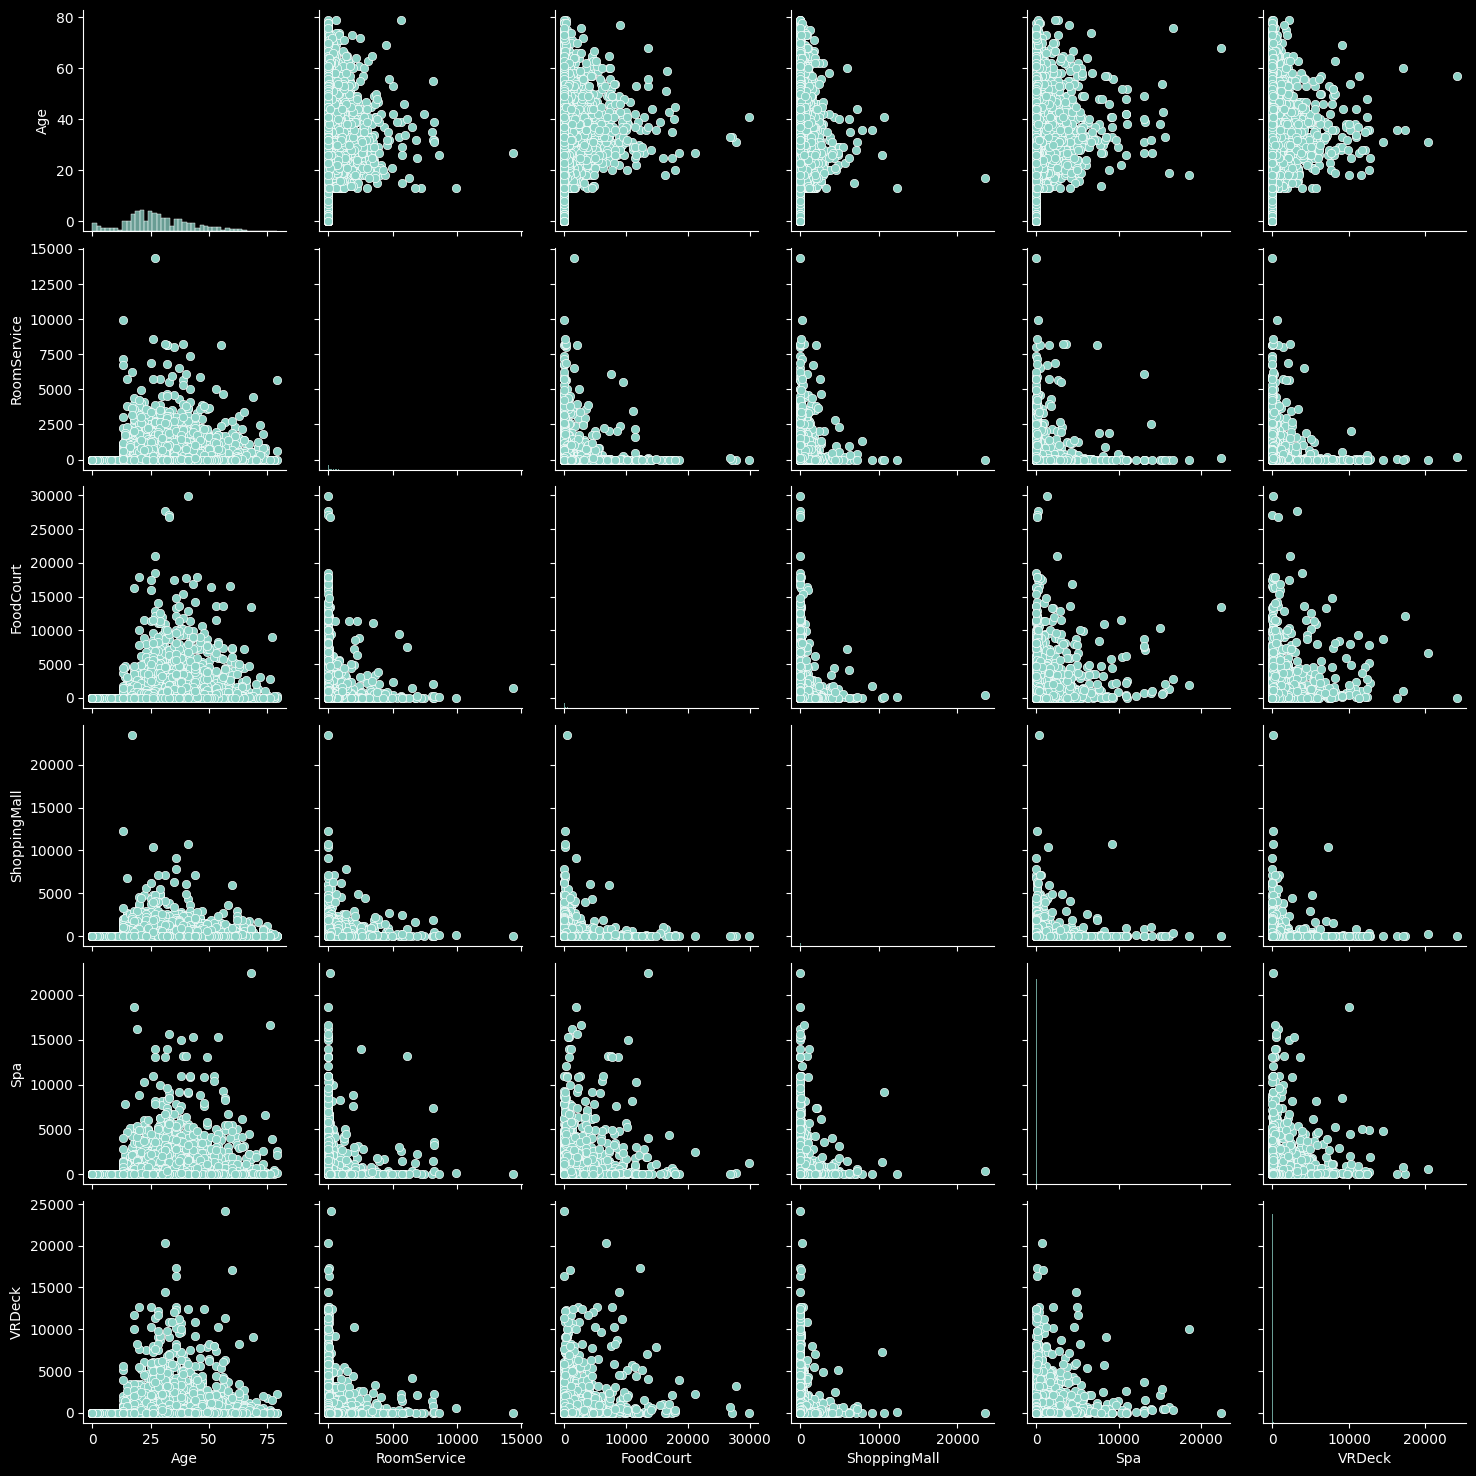

In [148]:
import seaborn as sns

sns.pairplot(df_train[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]])


In [149]:
from sklearn.pipeline import make_pipeline, FeatureUnion, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from catboost import CatBoostClassifier

money_features = ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"]

pipe = Pipeline(
    [
        (
            "features",
            FeatureUnion(
                [
                    (
                        "add_total_spent",
                        make_pipeline(
                            FunctionTransformer(
                                lambda df: df[money_features].sum(axis=1).to_numpy()[:, None],
                                feature_names_out=lambda self, _: ["TotalSpent"],
                            ),
                            QuantileTransformer(),
                        ),
                    ),
                    (
                        "fillna",
                        ColumnTransformer(
                            [
                                (
                                    "Age",
                                    make_pipeline(
                                        SimpleImputer(strategy="most_frequent"), QuantileTransformer(n_quantiles=50)
                                    ),
                                    ["Age"],
                                ),
                                (
                                    "quant_money",
                                    make_pipeline(
                                        SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()
                                    ),
                                    ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"],
                                ),
                                (
                                    "false_most_freq",
                                    SimpleImputer(strategy="most_frequent", fill_value=False),
                                    ["CryoSleep", "VIP"],
                                ),
                                (
                                    "HomePlanet",
                                    make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                                    ["HomePlanet"],
                                ),
                            ],
                            verbose_feature_names_out=False,
                        ),
                    ),
                ]
            ),
        ),
        ("model", CatBoostClassifier(random_state=rs, verbose=False)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=scoring_funcs)
metrics.from_cv("add_total_spent", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069
add_vip,0.718492,0.665369,0.700104
add_FoodCourt,0.728253,0.719732,0.723341
add_VRDeck,0.751143,0.746003,0.747155


In [150]:
from sklearn.pipeline import make_pipeline, FeatureUnion, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from catboost import CatBoostClassifier

money_features = ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"]

pipe = Pipeline(
    [
        (
            "features",
            FeatureUnion(
                [
                    (
                        "fillna",
                        ColumnTransformer(
                            [
                                (
                                    "Age",
                                    make_pipeline(
                                        SimpleImputer(strategy="most_frequent"), QuantileTransformer(n_quantiles=50)
                                    ),
                                    ["Age"],
                                ),
                                (
                                    "quant_money",
                                    make_pipeline(
                                        SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()
                                    ),
                                    ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"],
                                ),
                                (
                                    "false_most_freq",
                                    SimpleImputer(strategy="most_frequent", fill_value=False),
                                    ["CryoSleep", "VIP"],
                                ),
                                (
                                    "HomePlanet",
                                    make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                                    ["HomePlanet"],
                                ),
                            ],
                            verbose_feature_names_out=False,
                        ),
                    ),
                    (
                        "add_cab_features",
                        make_pipeline(
                            FunctionTransformer(
                                lambda df: df["Cabin"].str.split("/", expand=True),
                                feature_names_out=lambda self, _: ["CabLetter", "CabNumber", "CabSide"],
                            ),
                        ),
                    ),
                ]
            ),
        ),
        (
            "post_process",
            ColumnTransformer(
                [
                    (
                        "CabNumber",
                        make_pipeline(
                            SimpleImputer(fill_value=-1),
                            FunctionTransformer(
                                lambda df: df.astype(int), feature_names_out=lambda _, _0: ["CabNumber"]
                            ),
                        ),
                        [-2],
                    ),
                    ("ohe", OneHotEncoder(), [-1, -3]),
                ],
                remainder="passthrough",
            ),
        ),
        ("model", CatBoostClassifier(random_seed=42, verbose=False)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=scoring_funcs)
metrics.from_cv("add_cab_number", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069
add_vip,0.718492,0.665369,0.700104
add_FoodCourt,0.728253,0.719732,0.723341
add_VRDeck,0.751143,0.746003,0.747155


In [151]:
from sklearn.pipeline import make_pipeline, FeatureUnion, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from catboost import CatBoostClassifier

money_features = ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"]

pipe = Pipeline(
    [
        (
            "features",
            FeatureUnion(
                [
                    (
                        "fillna",
                        ColumnTransformer(
                            [
                                (
                                    "Age",
                                    make_pipeline(
                                        SimpleImputer(strategy="most_frequent"),
                                        QuantileTransformer(n_quantiles=50),
                                        StandardScaler(),
                                    ),
                                    ["Age"],
                                ),
                                (
                                    "quant_money",
                                    make_pipeline(
                                        SimpleImputer(strategy="constant", fill_value=0),
                                        QuantileTransformer(),
                                        StandardScaler(),
                                    ),
                                    ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"],
                                ),
                                (
                                    "false_most_freq",
                                    SimpleImputer(strategy="most_frequent", fill_value=False),
                                    ["CryoSleep", "VIP"],
                                ),
                                (
                                    "HomePlanet",
                                    make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                                    ["HomePlanet"],
                                ),
                            ],
                            verbose_feature_names_out=False,
                        ),
                    ),
                    (
                        "add_cab_features",
                        make_pipeline(
                            FunctionTransformer(
                                lambda df: df["Cabin"].str.split("/", expand=True),
                                feature_names_out=lambda self, _: ["CabLetter", "CabNumber", "CabSide"],
                            ),
                        ),
                    ),
                ]
            ),
        ),
        (
            "post_process",
            ColumnTransformer(
                [
                    (
                        "CabNumber",
                        make_pipeline(
                            SimpleImputer(fill_value=-1),
                            FunctionTransformer(
                                lambda df: df.astype(int), feature_names_out=lambda _, _0: ["CabNumber"]
                            ),
                        ),
                        [-2],
                    ),
                    ("ohe", OneHotEncoder(), [-1, -3]),
                ],
                remainder="passthrough",
            ),
        ),
        ("model", CatBoostClassifier(random_seed=42, verbose=False)),
    ]
)

cv = cross_validate(pipe, x, y, scoring=scoring_funcs)
metrics.from_cv("add_quant_scaler", cv)
metrics.as_pandas()


,precision,recall,accuracy
main,0.542157,0.438332,0.530198
baseline,0.503624,1.000000,0.503624
add_room_service,0.595562,0.844452,0.632810
add_cryo_sleep,0.713659,0.673824,0.699416
add_cryo_sleep_2,0.713659,0.673824,0.699416
add_home_planet,0.718458,0.662399,0.699184
add_home_planet_ord,0.718047,0.663085,0.699069
add_vip,0.718492,0.665369,0.700104
add_FoodCourt,0.728253,0.719732,0.723341
add_VRDeck,0.751143,0.746003,0.747155


In [152]:
pipe


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('fillna',
                                                 ColumnTransformer(transformers=[('Age',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('quantiletransformer',
                                                                                                   QuantileTransformer(n_quantiles=50)),
                                                                                                  ('standardscaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Age']),
                                                                                 ('quant_money',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('CabNumber',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=-1)),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function <lambda> at 0x165ca27a0>,
                                                                                       func=<function <lambda> at 0x165ca2520>))]),
                                                  [-2]),
                                                 ('ohe', OneHotEncoder(),
                                                  [-1, -3])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x165cbc910>)])

In [159]:
# final model
import numpy as np
from sklearn.pipeline import make_pipeline, FeatureUnion, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from catboost import CatBoostClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

money_features = ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"]
space = {
    "num_trees": hp.quniform("num_trees", 100, 200, 10),
    "learning_rate": hp.uniform("learning_rate", 0, 0.3),
    "depth": hp.quniform("depth", 2, 9, 1),
    "l2_leaf_reg": hp.uniform("l2_leaf_reg", 1, 10),
    "bagging_temperature": hp.uniform("bagging_temperature", 1, 10),
    "seed": 0,
}

pipe = Pipeline(
    [
        (
            "features",
            FeatureUnion(
                [
                    (
                        "fillna",
                        ColumnTransformer(
                            [
                                (
                                    "Age",
                                    make_pipeline(
                                        SimpleImputer(strategy="most_frequent"), QuantileTransformer(n_quantiles=50)
                                    ),
                                    ["Age"],
                                ),
                                (
                                    "quant_money",
                                    make_pipeline(
                                        SimpleImputer(strategy="constant", fill_value=0), QuantileTransformer()
                                    ),
                                    ["RoomService", "FoodCourt", "VRDeck", "Spa", "ShoppingMall"],
                                ),
                                (
                                    "false_most_freq",
                                    SimpleImputer(strategy="most_frequent", fill_value=False),
                                    ["CryoSleep", "VIP"],
                                ),
                                (
                                    "HomePlanet",
                                    make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
                                    ["HomePlanet"],
                                ),
                            ],
                            verbose_feature_names_out=False,
                        ),
                    ),
                    (
                        "add_cab_features",
                        make_pipeline(
                            FunctionTransformer(
                                lambda df: df["Cabin"].str.split("/", expand=True),
                                feature_names_out=lambda self, _: ["CabLetter", "CabNumber", "CabSide"],
                            ),
                        ),
                    ),
                ]
            ),
        ),
        (
            "post_process",
            ColumnTransformer(
                [
                    (
                        "CabNumber",
                        make_pipeline(
                            SimpleImputer(fill_value=-1),
                            FunctionTransformer(
                                lambda df: df.astype(int), feature_names_out=lambda _, _0: ["CabNumber"]
                            ),
                        ),
                        [-2],
                    ),
                    ("ohe", OneHotEncoder(), [-1, -3]),
                ],
                remainder="passthrough",
            ),
        ),
        ("model", CatBoostClassifier(random_seed=42, verbose=False)),
    ]
)


def objective(space):
    model = pipe.set_params(
        model__num_trees=int(space["num_trees"]),
        model__learning_rate=space["learning_rate"],
        model__depth=int(space["depth"]),
        model__l2_leaf_reg=space["l2_leaf_reg"],
        model__bagging_temperature=space["bagging_temperature"],
    )

    cv = cross_validate(pipe, x, y, scoring=scoring_funcs, n_jobs=-1)
    return {"loss": 1 - np.mean(cv["test_accuracy"]), "status": STATUS_OK, "model": model}


trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=500, trials=trials)
# metrics.from_cv("final_model", cv)
# metrics.as_pandas()


100%|██████████| 500/500 [11:48<00:00,  1.42s/trial, best loss: 0.1972820775136963] 


In [167]:
best_hyperparams

{'bagging_temperature': 2.380249955633156,
 'depth': 8.0,
 'l2_leaf_reg': 7.342778007475186,
 'learning_rate': 0.028814427613815457,
 'num_trees': 110.0}

In [161]:
pipe.set_params(**{f"model__{k}": v for k, v in best_hyperparams.items()})
pipe.fit(x, y)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('fillna',
                                                 ColumnTransformer(transformers=[('Age',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('quantiletransformer',
                                                                                                   QuantileTransformer(n_quantiles=50))]),
                                                                                  ['Age']),
                                                                                 ('quant_money',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(fill_value=0,
                                                                                                                 strategy='constant')),...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('CabNumber',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=-1)),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function <lambda> at 0x16726b4c0>,
                                                                                       func=<function <lambda> at 0x16726b240>))]),
                                                  [-2]),
                                                 ('ohe', OneHotEncoder(),
                                                  [-1, -3])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x166d385d0>)])

In [166]:
from pathlib import Path

pd.DataFrame({"Transported": ["True" if x else "False" for x in pipe.predict(df_test)]}, index=df_test.index).to_csv(Path() / "data" / "submission.csv")
